# Parte practica parcial modelos predictivos

### Redes neuronales recurrentes para la TRM


Para mas información ir a https://github.com/svelezh/Parcial_3

## Librerias

In [11]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense,SimpleRNN,GRU
from keras.regularizers import l1

In [12]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

## Carga de datos TRM

In [14]:
trm=pd.read_csv("TRM.csv")
trm.VIGENCIADESDE=pd.to_datetime(trm.VIGENCIADESDE,format='%d/%m/%Y')
trm.set_index(pd.DatetimeIndex(trm.VIGENCIADESDE),inplace=True)

In [15]:
trm_mensual=trm.resample(rule="M").last()
trm_mensual.drop(['UNIDAD', 'VIGENCIADESDE', 'VIGENCIAHASTA'],inplace=True,axis=1)
df=trm_mensual

## Identificacion

In [16]:
split = "2018-12"

df_train = df[:split]
df_test = df.loc["2019-01-31":"2019-09-30"]
df_test1=df_test.copy()

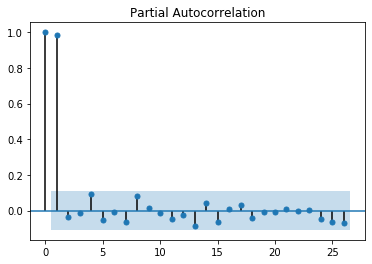

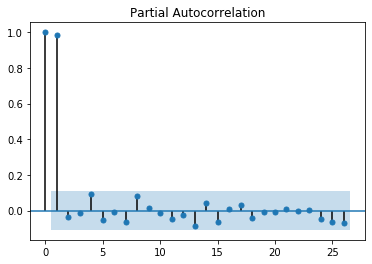

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_train)

Usaremos dos modelos, el primero un RNN(1) y un RNN(4)

Se estandarizan los datos

In [18]:
scaler=StandardScaler()

train=scaler.fit_transform(df_train.values.reshape(-1,1))
test=scaler.fit_transform(df_test.values.reshape(-1,1))

df_train=pd.DataFrame(train, index=df_train.index,columns=df_train.columns)
df_test=pd.DataFrame(test, index=df_test.index,columns=df_test.columns)

## Red neuronal recurrente simple

In [22]:
def RNN_TRM(neuronas,reg):
    model = Sequential()
    model.add(SimpleRNN(neuronas, activation="relu",kernel_regularizer=l1(reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True, stateful=False))  
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

Keras utiliza una estructura especial para la estimacion de los modelos de redes neuronales para esto se emplea la siguiente función, la cual tiene por argumentos el dataframe, el numero de rezagos a considerar y el horizonte de pronostico (Bilokon, Dixon & Halperin,2020)

In [19]:
def get_lagged_features(df, lags, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(lags + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[lags+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

### RNN(1)

In [20]:
lags,n_steps_ahead=1,1

x_train = get_lagged_features(df_train, lags, n_steps_ahead)
y_train =  df_train.values[lags + n_steps_ahead - 1:]
y_train_timestamps = df_train.index[lags + n_steps_ahead - 1:]

x_test = get_lagged_features(df_test, lags, n_steps_ahead)
y_test =  df_test.values[lags + n_steps_ahead - 1:]
y_test_timestamps = df_test.index[lags + n_steps_ahead - 1:]

In [428]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(324, 1, 1), (324, 1), (8, 1, 1), (8, 1)]


### Cross-validation

Se realiza el proceso de CV para el número de neuronas en la capa y el parametro de regularización

In [23]:
neuronas = [50,100,200]
reg = [0.001, 0.01, 0.1] 
param_grid = {'neuronas': neuronas, 'reg': reg}
tscv = TimeSeriesSplit(n_splits = 5)

model=KerasRegressor(build_fn=RNN_TRM, epochs=30, verbose=2)
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1,verbose=1)
    grid_result = grid.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
2/2 - 0s - loss: 2.5564
Epoch 2/30
2/2 - 0s - loss: 2.4388
Epoch 3/30
2/2 - 0s - loss: 2.3259
Epoch 4/30
2/2 - 0s - loss: 2.2166
Epoch 5/30
2/2 - 0s - loss: 2.1087
Epoch 6/30
2/2 - 0s - loss: 2.0042
Epoch 7/30
2/2 - 0s - loss: 1.9038
Epoch 8/30
2/2 - 0s - loss: 1.8050
Epoch 9/30
2/2 - 0s - loss: 1.7104
Epoch 10/30
2/2 - 0s - loss: 1.6227
Epoch 11/30
2/2 - 0s - loss: 1.5380
Epoch 12/30
2/2 - 0s - loss: 1.4538
Epoch 13/30
2/2 - 0s - loss: 1.3757
Epoch 14/30
2/2 - 0s - loss: 1.2986
Epoch 15/30
2/2 - 0s - loss: 1.2284
Epoch 16/30
2/2 - 0s - loss: 1.1614
Epoch 17/30
2/2 - 0s - loss: 1.0970
Epoch 18/30
2/2 - 0s - loss: 1.0362
Epoch 19/30
2/2 - 0s - loss: 0.9777
Epoch 20/30
2/2 - 0s - loss: 0.9215
Epoch 21/30
2/2 - 0s - loss: 0.8665
Epoch 22/30
2/2 - 0s - loss: 0.8140
Epoch 23/30
2/2 - 0s - loss: 0.7649
Epoch 24/30
2/2 - 0s - loss: 0.7168
Epoch 25/30
2/2 - 0s - loss: 0.6707
Epoch 26/30
2/2 - 0s - loss: 0.6271
Epoch 27/30
2/2 - 0s - loss: 0.5853
Epoch 28/30
2/2 - 0s - loss: 0.5443
E

2/2 - 0s - loss: 0.1467
Epoch 1/30
4/4 - 0s - loss: 2.2189
Epoch 2/30
4/4 - 0s - loss: 2.0543
Epoch 3/30
4/4 - 0s - loss: 1.8963
Epoch 4/30
4/4 - 0s - loss: 1.7528
Epoch 5/30
4/4 - 0s - loss: 1.6144
Epoch 6/30
4/4 - 0s - loss: 1.4841
Epoch 7/30
4/4 - 0s - loss: 1.3605
Epoch 8/30
4/4 - 0s - loss: 1.2465
Epoch 9/30
4/4 - 0s - loss: 1.1333
Epoch 10/30
4/4 - 0s - loss: 1.0347
Epoch 11/30
4/4 - 0s - loss: 0.9381
Epoch 12/30
4/4 - 0s - loss: 0.8491
Epoch 13/30
4/4 - 0s - loss: 0.7636
Epoch 14/30
4/4 - 0s - loss: 0.6909
Epoch 15/30
4/4 - 0s - loss: 0.6201
Epoch 16/30
4/4 - 0s - loss: 0.5586
Epoch 17/30
4/4 - 0s - loss: 0.4991
Epoch 18/30
4/4 - 0s - loss: 0.4474
Epoch 19/30
4/4 - 0s - loss: 0.3993
Epoch 20/30
4/4 - 0s - loss: 0.3562
Epoch 21/30
4/4 - 0s - loss: 0.3201
Epoch 22/30
4/4 - 0s - loss: 0.2832
Epoch 23/30
4/4 - 0s - loss: 0.2526
Epoch 24/30
4/4 - 0s - loss: 0.2245
Epoch 25/30
4/4 - 0s - loss: 0.2008
Epoch 26/30
4/4 - 0s - loss: 0.1794
Epoch 27/30
4/4 - 0s - loss: 0.1616
Epoch 28/30
4

Epoch 23/30
2/2 - 0s - loss: 1.4895
Epoch 24/30
2/2 - 0s - loss: 1.4401
Epoch 25/30
2/2 - 0s - loss: 1.3923
Epoch 26/30
2/2 - 0s - loss: 1.3476
Epoch 27/30
2/2 - 0s - loss: 1.3042
Epoch 28/30
2/2 - 0s - loss: 1.2634
Epoch 29/30
2/2 - 0s - loss: 1.2237
Epoch 30/30
2/2 - 0s - loss: 1.1870
2/2 - 0s - loss: 0.8944
Epoch 1/30
4/4 - 0s - loss: 2.3775
Epoch 2/30
4/4 - 0s - loss: 2.2429
Epoch 3/30
4/4 - 0s - loss: 2.1077
Epoch 4/30
4/4 - 0s - loss: 1.9876
Epoch 5/30
4/4 - 0s - loss: 1.8687
Epoch 6/30
4/4 - 0s - loss: 1.7602
Epoch 7/30
4/4 - 0s - loss: 1.6579
Epoch 8/30
4/4 - 0s - loss: 1.5599
Epoch 9/30
4/4 - 0s - loss: 1.4664
Epoch 10/30
4/4 - 0s - loss: 1.3818
Epoch 11/30
4/4 - 0s - loss: 1.3021
Epoch 12/30
4/4 - 0s - loss: 1.2264
Epoch 13/30
4/4 - 0s - loss: 1.1591
Epoch 14/30
4/4 - 0s - loss: 1.0954
Epoch 15/30
4/4 - 0s - loss: 1.0375
Epoch 16/30
4/4 - 0s - loss: 0.9867
Epoch 17/30
4/4 - 0s - loss: 0.9369
Epoch 18/30
4/4 - 0s - loss: 0.8951
Epoch 19/30
4/4 - 0s - loss: 0.8548
Epoch 20/30
4

2/2 - 0s - loss: 0.6030
Epoch 1/30
2/2 - 0s - loss: 2.0291
Epoch 2/30
2/2 - 0s - loss: 1.8744
Epoch 3/30
2/2 - 0s - loss: 1.7289
Epoch 4/30
2/2 - 0s - loss: 1.5908
Epoch 5/30
2/2 - 0s - loss: 1.4573
Epoch 6/30
2/2 - 0s - loss: 1.3312
Epoch 7/30
2/2 - 0s - loss: 1.2105
Epoch 8/30
2/2 - 0s - loss: 1.0985
Epoch 9/30
2/2 - 0s - loss: 0.9921
Epoch 10/30
2/2 - 0s - loss: 0.8929
Epoch 11/30
2/2 - 0s - loss: 0.7983
Epoch 12/30
2/2 - 0s - loss: 0.7102
Epoch 13/30
2/2 - 0s - loss: 0.6270
Epoch 14/30
2/2 - 0s - loss: 0.5517
Epoch 15/30
2/2 - 0s - loss: 0.4813
Epoch 16/30
2/2 - 0s - loss: 0.4166
Epoch 17/30
2/2 - 0s - loss: 0.3580
Epoch 18/30
2/2 - 0s - loss: 0.3053
Epoch 19/30
2/2 - 0s - loss: 0.2573
Epoch 20/30
2/2 - 0s - loss: 0.2153
Epoch 21/30
2/2 - 0s - loss: 0.1787
Epoch 22/30
2/2 - 0s - loss: 0.1464
Epoch 23/30
2/2 - 0s - loss: 0.1183
Epoch 24/30
2/2 - 0s - loss: 0.0951
Epoch 25/30
2/2 - 0s - loss: 0.0754
Epoch 26/30
2/2 - 0s - loss: 0.0593
Epoch 27/30
2/2 - 0s - loss: 0.0463
Epoch 28/30
2

Epoch 23/30
9/9 - 0s - loss: 0.0283
Epoch 24/30
9/9 - 0s - loss: 0.0280
Epoch 25/30
9/9 - 0s - loss: 0.0279
Epoch 26/30
9/9 - 0s - loss: 0.0274
Epoch 27/30
9/9 - 0s - loss: 0.0271
Epoch 28/30
9/9 - 0s - loss: 0.0268
Epoch 29/30
9/9 - 0s - loss: 0.0265
Epoch 30/30
9/9 - 0s - loss: 0.0263
2/2 - 0s - loss: 0.0829
Epoch 1/30
2/2 - 0s - loss: 2.5813
Epoch 2/30
2/2 - 0s - loss: 2.3746
Epoch 3/30
2/2 - 0s - loss: 2.1792
Epoch 4/30
2/2 - 0s - loss: 1.9956
Epoch 5/30
2/2 - 0s - loss: 1.8185
Epoch 6/30
2/2 - 0s - loss: 1.6551
Epoch 7/30
2/2 - 0s - loss: 1.4993
Epoch 8/30
2/2 - 0s - loss: 1.3597
Epoch 9/30
2/2 - 0s - loss: 1.2268
Epoch 10/30
2/2 - 0s - loss: 1.1031
Epoch 11/30
2/2 - 0s - loss: 0.9890
Epoch 12/30
2/2 - 0s - loss: 0.8825
Epoch 13/30
2/2 - 0s - loss: 0.7862
Epoch 14/30
2/2 - 0s - loss: 0.6978
Epoch 15/30
2/2 - 0s - loss: 0.6177
Epoch 16/30
2/2 - 0s - loss: 0.5443
Epoch 17/30
2/2 - 0s - loss: 0.4797
Epoch 18/30
2/2 - 0s - loss: 0.4223
Epoch 19/30
2/2 - 0s - loss: 0.3705
Epoch 20/30
2

2/2 - 0s - loss: 0.1081
Epoch 1/30
9/9 - 0s - loss: 0.4654
Epoch 2/30
9/9 - 0s - loss: 0.3245
Epoch 3/30
9/9 - 0s - loss: 0.2307
Epoch 4/30
9/9 - 0s - loss: 0.1763
Epoch 5/30
9/9 - 0s - loss: 0.1492
Epoch 6/30
9/9 - 0s - loss: 0.1391
Epoch 7/30
9/9 - 0s - loss: 0.1342
Epoch 8/30
9/9 - 0s - loss: 0.1309
Epoch 9/30
9/9 - 0s - loss: 0.1279
Epoch 10/30
9/9 - 0s - loss: 0.1248
Epoch 11/30
9/9 - 0s - loss: 0.1217
Epoch 12/30
9/9 - 0s - loss: 0.1188
Epoch 13/30
9/9 - 0s - loss: 0.1161
Epoch 14/30
9/9 - 0s - loss: 0.1136
Epoch 15/30
9/9 - 0s - loss: 0.1109
Epoch 16/30
9/9 - 0s - loss: 0.1083
Epoch 17/30
9/9 - 0s - loss: 0.1057
Epoch 18/30
9/9 - 0s - loss: 0.1033
Epoch 19/30
9/9 - 0s - loss: 0.1008
Epoch 20/30
9/9 - 0s - loss: 0.0985
Epoch 21/30
9/9 - 0s - loss: 0.0960
Epoch 22/30
9/9 - 0s - loss: 0.0937
Epoch 23/30
9/9 - 0s - loss: 0.0915
Epoch 24/30
9/9 - 0s - loss: 0.0893
Epoch 25/30
9/9 - 0s - loss: 0.0872
Epoch 26/30
9/9 - 0s - loss: 0.0851
Epoch 27/30
9/9 - 0s - loss: 0.0830
Epoch 28/30
9

Epoch 23/30
7/7 - 0s - loss: 0.5270
Epoch 24/30
7/7 - 0s - loss: 0.5047
Epoch 25/30
7/7 - 0s - loss: 0.4833
Epoch 26/30
7/7 - 0s - loss: 0.4627
Epoch 27/30
7/7 - 0s - loss: 0.4428
Epoch 28/30
7/7 - 0s - loss: 0.4244
Epoch 29/30
7/7 - 0s - loss: 0.4056
Epoch 30/30
7/7 - 0s - loss: 0.3890
2/2 - 0s - loss: 0.3424
Epoch 1/30
9/9 - 0s - loss: 1.8942
Epoch 2/30
9/9 - 0s - loss: 1.6902
Epoch 3/30
9/9 - 0s - loss: 1.5164
Epoch 4/30
9/9 - 0s - loss: 1.3806
Epoch 5/30
9/9 - 0s - loss: 1.2601
Epoch 6/30
9/9 - 0s - loss: 1.1614
Epoch 7/30
9/9 - 0s - loss: 1.0758
Epoch 8/30
9/9 - 0s - loss: 0.9992
Epoch 9/30
9/9 - 0s - loss: 0.9297
Epoch 10/30
9/9 - 0s - loss: 0.8668
Epoch 11/30
9/9 - 0s - loss: 0.8096
Epoch 12/30
9/9 - 0s - loss: 0.7553
Epoch 13/30
9/9 - 0s - loss: 0.7041
Epoch 14/30
9/9 - 0s - loss: 0.6554
Epoch 15/30
9/9 - 0s - loss: 0.6106
Epoch 16/30
9/9 - 0s - loss: 0.5704
Epoch 17/30
9/9 - 0s - loss: 0.5343
Epoch 18/30
9/9 - 0s - loss: 0.5028
Epoch 19/30
9/9 - 0s - loss: 0.4730
Epoch 20/30
9

2/2 - 0s - loss: 0.0535
Epoch 1/30
7/7 - 0s - loss: 1.0111
Epoch 2/30
7/7 - 0s - loss: 0.7298
Epoch 3/30
7/7 - 0s - loss: 0.5208
Epoch 4/30
7/7 - 0s - loss: 0.3554
Epoch 5/30
7/7 - 0s - loss: 0.2445
Epoch 6/30
7/7 - 0s - loss: 0.1653
Epoch 7/30
7/7 - 0s - loss: 0.1117
Epoch 8/30
7/7 - 0s - loss: 0.0741
Epoch 9/30
7/7 - 0s - loss: 0.0527
Epoch 10/30
7/7 - 0s - loss: 0.0453
Epoch 11/30
7/7 - 0s - loss: 0.0421
Epoch 12/30
7/7 - 0s - loss: 0.0415
Epoch 13/30
7/7 - 0s - loss: 0.0408
Epoch 14/30
7/7 - 0s - loss: 0.0402
Epoch 15/30
7/7 - 0s - loss: 0.0393
Epoch 16/30
7/7 - 0s - loss: 0.0387
Epoch 17/30
7/7 - 0s - loss: 0.0380
Epoch 18/30
7/7 - 0s - loss: 0.0374
Epoch 19/30
7/7 - 0s - loss: 0.0368
Epoch 20/30
7/7 - 0s - loss: 0.0363
Epoch 21/30
7/7 - 0s - loss: 0.0357
Epoch 22/30
7/7 - 0s - loss: 0.0352
Epoch 23/30
7/7 - 0s - loss: 0.0346
Epoch 24/30
7/7 - 0s - loss: 0.0342
Epoch 25/30
7/7 - 0s - loss: 0.0336
Epoch 26/30
7/7 - 0s - loss: 0.0331
Epoch 27/30
7/7 - 0s - loss: 0.0326
Epoch 28/30
7

Epoch 23/30
6/6 - 0s - loss: 0.1569
Epoch 24/30
6/6 - 0s - loss: 0.1542
Epoch 25/30
6/6 - 0s - loss: 0.1516
Epoch 26/30
6/6 - 0s - loss: 0.1491
Epoch 27/30
6/6 - 0s - loss: 0.1467
Epoch 28/30
6/6 - 0s - loss: 0.1447
Epoch 29/30
6/6 - 0s - loss: 0.1421
Epoch 30/30
6/6 - 0s - loss: 0.1392
2/2 - 0s - loss: 0.1573
Epoch 1/30
7/7 - 0s - loss: 1.2355
Epoch 2/30
7/7 - 0s - loss: 0.9323
Epoch 3/30
7/7 - 0s - loss: 0.6975
Epoch 4/30
7/7 - 0s - loss: 0.5185
Epoch 5/30
7/7 - 0s - loss: 0.3863
Epoch 6/30
7/7 - 0s - loss: 0.2981
Epoch 7/30
7/7 - 0s - loss: 0.2405
Epoch 8/30
7/7 - 0s - loss: 0.2081
Epoch 9/30
7/7 - 0s - loss: 0.1928
Epoch 10/30
7/7 - 0s - loss: 0.1843
Epoch 11/30
7/7 - 0s - loss: 0.1794
Epoch 12/30
7/7 - 0s - loss: 0.1746
Epoch 13/30
7/7 - 0s - loss: 0.1697
Epoch 14/30
7/7 - 0s - loss: 0.1649
Epoch 15/30
7/7 - 0s - loss: 0.1603
Epoch 16/30
7/7 - 0s - loss: 0.1559
Epoch 17/30
7/7 - 0s - loss: 0.1516
Epoch 18/30
7/7 - 0s - loss: 0.1475
Epoch 19/30
7/7 - 0s - loss: 0.1432
Epoch 20/30
7

2/2 - 0s - loss: 1.1109
Epoch 1/30
6/6 - 0s - loss: 3.2788
Epoch 2/30
6/6 - 0s - loss: 2.8327
Epoch 3/30
6/6 - 0s - loss: 2.4725
Epoch 4/30
6/6 - 0s - loss: 2.1820
Epoch 5/30
6/6 - 0s - loss: 1.9409
Epoch 6/30
6/6 - 0s - loss: 1.7547
Epoch 7/30
6/6 - 0s - loss: 1.6077
Epoch 8/30
6/6 - 0s - loss: 1.4900
Epoch 9/30
6/6 - 0s - loss: 1.3930
Epoch 10/30
6/6 - 0s - loss: 1.3064
Epoch 11/30
6/6 - 0s - loss: 1.2272
Epoch 12/30
6/6 - 0s - loss: 1.1535
Epoch 13/30
6/6 - 0s - loss: 1.0843
Epoch 14/30
6/6 - 0s - loss: 1.0177
Epoch 15/30
6/6 - 0s - loss: 0.9581
Epoch 16/30
6/6 - 0s - loss: 0.9035
Epoch 17/30
6/6 - 0s - loss: 0.8508
Epoch 18/30
6/6 - 0s - loss: 0.8023
Epoch 19/30
6/6 - 0s - loss: 0.7585
Epoch 20/30
6/6 - 0s - loss: 0.7187
Epoch 21/30
6/6 - 0s - loss: 0.6838
Epoch 22/30
6/6 - 0s - loss: 0.6506
Epoch 23/30
6/6 - 0s - loss: 0.6195
Epoch 24/30
6/6 - 0s - loss: 0.5894
Epoch 25/30
6/6 - 0s - loss: 0.5609
Epoch 26/30
6/6 - 0s - loss: 0.5355
Epoch 27/30
6/6 - 0s - loss: 0.5130
Epoch 28/30
6

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.1min finished


Epoch 1/30
11/11 - 0s - loss: 0.8147
Epoch 2/30
11/11 - 0s - loss: 0.5489
Epoch 3/30
11/11 - 0s - loss: 0.3492
Epoch 4/30
11/11 - 0s - loss: 0.2159
Epoch 5/30
11/11 - 0s - loss: 0.1323
Epoch 6/30
11/11 - 0s - loss: 0.0817
Epoch 7/30
11/11 - 0s - loss: 0.0554
Epoch 8/30
11/11 - 0s - loss: 0.0444
Epoch 9/30
11/11 - 0s - loss: 0.0404
Epoch 10/30
11/11 - 0s - loss: 0.0391
Epoch 11/30
11/11 - 0s - loss: 0.0385
Epoch 12/30
11/11 - 0s - loss: 0.0380
Epoch 13/30
11/11 - 0s - loss: 0.0374
Epoch 14/30
11/11 - 0s - loss: 0.0369
Epoch 15/30
11/11 - 0s - loss: 0.0363
Epoch 16/30
11/11 - 0s - loss: 0.0358
Epoch 17/30
11/11 - 0s - loss: 0.0352
Epoch 18/30
11/11 - 0s - loss: 0.0346
Epoch 19/30
11/11 - 0s - loss: 0.0341
Epoch 20/30
11/11 - 0s - loss: 0.0336
Epoch 21/30
11/11 - 0s - loss: 0.0332
Epoch 22/30
11/11 - 0s - loss: 0.0327
Epoch 23/30
11/11 - 0s - loss: 0.0322
Epoch 24/30
11/11 - 0s - loss: 0.0317
Epoch 25/30
11/11 - 0s - loss: 0.0313
Epoch 26/30
11/11 - 0s - loss: 0.0308
Epoch 27/30
11/11 - 0

In [24]:
neuronas,reg=grid_result.best_params_["neuronas"],grid_result.best_params_["reg"]
print("Número de neuronas:%i, Parametro de regularización:%f"%(neuronas,reg))

Número de neuronas:100, Parametro de regularización:0.001000


### Rolling window forecast

In [25]:
from datetime import datetime,timedelta
fecha_inicio,fecha_fin=pd.Timestamp('2010-12-31'),pd.Timestamp('2018-12-31')
trm_forecast1=[]
scaler=StandardScaler()
lags,n_steps_ahead=1,1

for i in range(9):
    inicio,fin=fecha_inicio+pd.DateOffset(months=i),fecha_fin+pd.DateOffset(months=i)

    ventana=df[inicio:fin]
    np_ventana=scaler.fit_transform(ventana.values.reshape(-1,1))
    ventana=pd.DataFrame(np_ventana, index=ventana.index,columns=ventana.columns)

    x_train = get_lagged_features(ventana, lags, n_steps_ahead)
    y_train =  ventana.values[lags + n_steps_ahead - 1:]
    y_train_timestamps = ventana.index[lags + n_steps_ahead - 1:]
 
    model=RNN_TRM(100,0.001)
    model.fit(x_train,y_train,epochs=50)
    trm_forecast=model.predict(x_train)[-1]
    trm_forecast=scaler.inverse_transform(trm_forecast)
    trm_forecast1.append(trm_forecast[0])

Epoch 1/50
3/3 [==============================] - 0s 1ms/step - loss: 0.7230
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6418
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 0.5668
Epoch 4/50
3/3 [==============================] - 0s 3ms/step - loss: 0.4966
Epoch 5/50
3/3 [==============================] - 0s 3ms/step - loss: 0.4323
Epoch 6/50
3/3 [==============================] - 0s 4ms/step - loss: 0.3748
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 0.3235
Epoch 8/50
3/3 [==============================] - 0s 3ms/step - loss: 0.2782
Epoch 9/50
3/3 [==============================] - 0s 3ms/step - loss: 0.2362
Epoch 10/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1989
Epoch 11/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1677
Epoch 12/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1410
Epoch 13/50
3/3 [==============================] - 0s 2ms/step - loss: 0.

3/3 [==============================] - 0s 3ms/step - loss: 1.0037
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.9187
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.8360
Epoch 9/50
3/3 [==============================] - 0s 3ms/step - loss: 0.7630
Epoch 10/50
3/3 [==============================] - 0s 996us/step - loss: 0.6933
Epoch 11/50
3/3 [==============================] - 0s 1ms/step - loss: 0.6297
Epoch 12/50
3/3 [==============================] - 0s 2ms/step - loss: 0.5693
Epoch 13/50
3/3 [==============================] - 0s 1ms/step - loss: 0.5148
Epoch 14/50
3/3 [==============================] - 0s 2ms/step - loss: 0.4630
Epoch 15/50
3/3 [==============================] - 0s 2ms/step - loss: 0.4168
Epoch 16/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3748
Epoch 17/50
3/3 [==============================] - 0s 1ms/step - loss: 0.3363
Epoch 18/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3009

3/3 [==============================] - 0s 2ms/step - loss: 0.2694
Epoch 12/50
3/3 [==============================] - 0s 4ms/step - loss: 0.2308
Epoch 13/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1962
Epoch 14/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1665
Epoch 15/50
3/3 [==============================] - ETA: 0s - loss: 0.133 - 0s 1ms/step - loss: 0.1409
Epoch 16/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1206
Epoch 17/50
3/3 [==============================] - 0s 3ms/step - loss: 0.1014
Epoch 18/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0869
Epoch 19/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0753
Epoch 20/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0660
Epoch 21/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0591
Epoch 22/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0541
Epoch 23/50
3/3 [==============================] - 0

Epoch 1/50
3/3 [==============================] - 0s 3ms/step - loss: 0.8041
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 0.7168
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6349
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.5598
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.4887
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.4222
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 0.3654
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3177
Epoch 9/50
3/3 [==============================] - 0s 3ms/step - loss: 0.2716
Epoch 10/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2328
Epoch 11/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2002
Epoch 12/50
3/3 [==============================] - 0s 3ms/step - loss: 0.1706
Epoch 13/50
3/3 [==============================] - 0s 3ms/step - loss: 0.

3/3 [==============================] - 0s 3ms/step - loss: 0.0445
Epoch 46/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0445
Epoch 47/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0444
Epoch 48/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0444
Epoch 49/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0444
Epoch 50/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0444
Epoch 1/50
3/3 [==============================] - 0s 4ms/step - loss: 1.0021
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 0.9001
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 0.8072
Epoch 4/50
3/3 [==============================] - 0s 4ms/step - loss: 0.7207
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.6407
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.5666
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.5012
Epoch

In [26]:
mean_absolute_error(df_test1,trm_forecast1)

127.07314127604165

### RNN(4)

### Rolling window forecast

In [27]:
from datetime import datetime,timedelta
fecha_inicio,fecha_fin=pd.Timestamp('2010-12-31'),pd.Timestamp('2018-12-31')
trm_forecast2=[]
scaler=StandardScaler()
lags,n_steps_ahead=4,1

for i in range(9):
    inicio,fin=fecha_inicio+pd.DateOffset(months=i),fecha_fin+pd.DateOffset(months=i)

    ventana=df[inicio:fin]
    np_ventana=scaler.fit_transform(ventana.values.reshape(-1,1))
    ventana=pd.DataFrame(np_ventana, index=ventana.index,columns=ventana.columns)

    x_train = get_lagged_features(ventana, lags, n_steps_ahead)
    y_train =  ventana.values[lags + n_steps_ahead - 1:]
    y_train_timestamps = ventana.index[lags + n_steps_ahead - 1:]
 
    model=RNN_TRM(100,0.001)
    model.fit(x_train,y_train,epochs=50)
    trm_forecast=model.predict(x_train)[-1]
    trm_forecast=scaler.inverse_transform(trm_forecast)
    trm_forecast2.append(trm_forecast[0])

Epoch 1/50
3/3 [==============================] - 0s 2ms/step - loss: 0.8512
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 0.4787
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 0.2270
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0964
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0772
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0969
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0919
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0660
Epoch 9/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0547
Epoch 10/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0582
Epoch 11/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0595
Epoch 12/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0547
Epoch 13/50
3/3 [==============================] - 0s 2ms/step - loss: 0.

3/3 [==============================] - 0s 4ms/step - loss: 0.0409
Epoch 47/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0407
Epoch 48/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0416
Epoch 49/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0408
Epoch 50/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0405
Epoch 1/50
3/3 [==============================] - 0s 2ms/step - loss: 0.8653
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 0.5121
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2612
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1232
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0687
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0901
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0986
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0751
Epoch 

3/3 [==============================] - 0s 3ms/step - loss: 0.0435
Epoch 32/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0432
Epoch 33/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0428
Epoch 34/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0433
Epoch 35/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0423
Epoch 36/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0425
Epoch 37/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0422
Epoch 38/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0419
Epoch 39/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0415
Epoch 40/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0415
Epoch 41/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0411
Epoch 42/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0413
Epoch 43/50
3/3 [==============================] - 0s 2ms/step - loss: 0.041

3/3 [==============================] - 0s 2ms/step - loss: 0.0497
Epoch 17/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0487
Epoch 18/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0480
Epoch 19/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0472
Epoch 20/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0466
Epoch 21/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0463
Epoch 22/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0456
Epoch 23/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0457
Epoch 24/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0452
Epoch 25/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0447
Epoch 26/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0444
Epoch 27/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0437
Epoch 28/50
3/3 [==============================] - 0s 2ms/step - loss: 0.043

3/3 [==============================] - 0s 3ms/step - loss: 0.8192
Epoch 2/50
3/3 [==============================] - 0s 2ms/step - loss: 0.4773
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2532
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1235
Epoch 5/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0720
Epoch 6/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0795
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0834
Epoch 8/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0700
Epoch 9/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0549
Epoch 10/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0566
Epoch 11/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0574
Epoch 12/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0520
Epoch 13/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0486
Epoch 

3/3 [==============================] - 0s 2ms/step - loss: 0.0414
Epoch 47/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0413
Epoch 48/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0414
Epoch 49/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0412
Epoch 50/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0407


In [28]:
mean_absolute_error(df_test1.values,trm_forecast2)

116.52520833333331

In [29]:
from dm_test import dm_test
rt = dm_test(df_test1["VALOR"].values.tolist(),trm_forecast1,trm_forecast2,h = 1, crit="MSE")
print(rt)

dm_return(DM=2.0222722412076632, p_value=0.07778403367516533)


## Redes neuronales recurrentes GRU

In [30]:
def GRU_TRM(neuronas,reg):
    model = Sequential()
    model.add(GRU(neuronas, activation='relu',kernel_regularizer=l1(reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [31]:
from datetime import datetime,timedelta
fecha_inicio,fecha_fin=pd.Timestamp('2010-12-31'),pd.Timestamp('2018-12-31')
trm_forecast3=[]
scaler=StandardScaler()
lags,n_steps_ahead=1,1

for i in range(9):
    inicio,fin=fecha_inicio+pd.DateOffset(months=i),fecha_fin+pd.DateOffset(months=i)

    ventana=df[inicio:fin]
    np_ventana=scaler.fit_transform(ventana.values.reshape(-1,1))
    ventana=pd.DataFrame(np_ventana, index=ventana.index,columns=ventana.columns)

    x_train = get_lagged_features(ventana, lags, n_steps_ahead)
    y_train =  ventana.values[lags + n_steps_ahead - 1:]
    y_train_timestamps = ventana.index[lags + n_steps_ahead - 1:]
 
    model=GRU_TRM(100,0.001)
    model.fit(x_train,y_train,epochs=50)
    trm_forecast=model.predict(x_train)[-1]
    trm_forecast=scaler.inverse_transform(trm_forecast)
    trm_forecast3.append(trm_forecast[0])

Epoch 1/50
3/3 [==============================] - 0s 4ms/step - loss: 1.0421
Epoch 2/50
3/3 [==============================] - 0s 4ms/step - loss: 0.9903
Epoch 3/50
3/3 [==============================] - 0s 4ms/step - loss: 0.9403
Epoch 4/50
3/3 [==============================] - 0s 4ms/step - loss: 0.8927
Epoch 5/50
3/3 [==============================] - 0s 3ms/step - loss: 0.8474
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.8046
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 0.7636
Epoch 8/50
3/3 [==============================] - 0s 4ms/step - loss: 0.7233
Epoch 9/50
3/3 [==============================] - 0s 4ms/step - loss: 0.6838
Epoch 10/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6462
Epoch 11/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6096
Epoch 12/50
3/3 [==============================] - 0s 4ms/step - loss: 0.5745
Epoch 13/50
3/3 [==============================] - 0s 4ms/step - loss: 0.

3/3 [==============================] - 0s 2ms/step - loss: 0.0423
Epoch 47/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0421
Epoch 48/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0420
Epoch 49/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0418
Epoch 50/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0417
Epoch 1/50
3/3 [==============================] - 0s 2ms/step - loss: 0.9630
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 0.9116
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 0.8637
Epoch 4/50
3/3 [==============================] - 0s 3ms/step - loss: 0.8190
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.7747
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.7318
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6901
Epoch 8/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6498
Epoch 

3/3 [==============================] - 0s 2ms/step - loss: 0.0732
Epoch 32/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0661
Epoch 33/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0604
Epoch 34/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0559
Epoch 35/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0528
Epoch 36/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0503
Epoch 37/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0485
Epoch 38/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0474
Epoch 39/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0461
Epoch 40/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0456
Epoch 41/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0451
Epoch 42/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0448
Epoch 43/50
3/3 [==============================] - 0s 4ms/step - loss: 0.044

3/3 [==============================] - 0s 3ms/step - loss: 0.3350
Epoch 17/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3051
Epoch 18/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2757
Epoch 19/50
3/3 [==============================] - 0s 3ms/step - loss: 0.2485
Epoch 20/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2242
Epoch 21/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1992
Epoch 22/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1782
Epoch 23/50
3/3 [==============================] - 0s 3ms/step - loss: 0.1583
Epoch 24/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1401
Epoch 25/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1237
Epoch 26/50
3/3 [==============================] - 0s 3ms/step - loss: 0.1095
Epoch 27/50
3/3 [==============================] - ETA: 0s - loss: 0.118 - 0s 2ms/step - loss: 0.0974
Epoch 28/50
3/3 [==============================] - 0

3/3 [==============================] - 0s 3ms/step - loss: 0.9314
Epoch 2/50
3/3 [==============================] - 0s 4ms/step - loss: 0.8784
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 0.8286
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.7810
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.7329
Epoch 6/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6869
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6445
Epoch 8/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6018
Epoch 9/50
3/3 [==============================] - 0s 3ms/step - loss: 0.5593
Epoch 10/50
3/3 [==============================] - 0s 2ms/step - loss: 0.5192
Epoch 11/50
3/3 [==============================] - 0s 2ms/step - loss: 0.4803
Epoch 12/50
3/3 [==============================] - 0s 2ms/step - loss: 0.4430
Epoch 13/50
3/3 [==============================] - 0s 2ms/step - loss: 0.4069
Epoch 

3/3 [==============================] - 0s 4ms/step - loss: 0.0473
Epoch 47/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0471
Epoch 48/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0469
Epoch 49/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0467
Epoch 50/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0466


In [32]:
mean_absolute_error(df_test1.values,trm_forecast3)

133.51515299479166

In [33]:
from datetime import datetime,timedelta
fecha_inicio,fecha_fin=pd.Timestamp('2010-12-31'),pd.Timestamp('2018-12-31')
trm_forecast4=[]
scaler=StandardScaler()
lags,n_steps_ahead=4,1

for i in range(9):
    inicio,fin=fecha_inicio+pd.DateOffset(months=i),fecha_fin+pd.DateOffset(months=i)

    ventana=df[inicio:fin]
    np_ventana=scaler.fit_transform(ventana.values.reshape(-1,1))
    ventana=pd.DataFrame(np_ventana, index=ventana.index,columns=ventana.columns)

    x_train = get_lagged_features(ventana, lags, n_steps_ahead)
    y_train =  ventana.values[lags + n_steps_ahead - 1:]
    y_train_timestamps = ventana.index[lags + n_steps_ahead - 1:]
 
    model=GRU_TRM(100,0.001)
    model.fit(x_train,y_train,epochs=50)
    trm_forecast=model.predict(x_train)[-1]
    trm_forecast=scaler.inverse_transform(trm_forecast)
    trm_forecast4.append(trm_forecast[0])

Epoch 1/50
3/3 [==============================] - 0s 4ms/step - loss: 0.9140
Epoch 2/50
3/3 [==============================] - 0s 4ms/step - loss: 0.7860
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6719
Epoch 4/50
3/3 [==============================] - 0s 3ms/step - loss: 0.5669
Epoch 5/50
3/3 [==============================] - 0s 3ms/step - loss: 0.4760
Epoch 6/50
3/3 [==============================] - 0s 3ms/step - loss: 0.3951
Epoch 7/50
3/3 [==============================] - 0s 4ms/step - loss: 0.3221
Epoch 8/50
3/3 [==============================] - 0s 3ms/step - loss: 0.2585
Epoch 9/50
3/3 [==============================] - 0s 4ms/step - loss: 0.2086
Epoch 10/50
3/3 [==============================] - 0s 4ms/step - loss: 0.1644
Epoch 11/50
3/3 [==============================] - 0s 3ms/step - loss: 0.1290
Epoch 12/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1013
Epoch 13/50
3/3 [==============================] - 0s 3ms/step - loss: 0.

3/3 [==============================] - 0s 3ms/step - loss: 0.0440
Epoch 47/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0436
Epoch 48/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0435
Epoch 49/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0434
Epoch 50/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0432
Epoch 1/50
3/3 [==============================] - 0s 4ms/step - loss: 1.0800
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 0.9457
Epoch 3/50
3/3 [==============================] - 0s 5ms/step - loss: 0.8295
Epoch 4/50
3/3 [==============================] - 0s 4ms/step - loss: 0.7222
Epoch 5/50
3/3 [==============================] - 0s 4ms/step - loss: 0.6223
Epoch 6/50
3/3 [==============================] - 0s 4ms/step - loss: 0.5312
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 0.4458
Epoch 8/50
3/3 [==============================] - 0s 4ms/step - loss: 0.3625
Epoch 

3/3 [==============================] - 0s 3ms/step - loss: 0.0480
Epoch 32/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0477
Epoch 33/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0474
Epoch 34/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0469
Epoch 35/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0467
Epoch 36/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0463
Epoch 37/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0460
Epoch 38/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0458
Epoch 39/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0455
Epoch 40/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0451
Epoch 41/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0450
Epoch 42/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0449
Epoch 43/50
3/3 [==============================] - 0s 2ms/step - loss: 0.044

3/3 [==============================] - 0s 4ms/step - loss: 0.0613
Epoch 17/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0578
Epoch 18/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0558
Epoch 19/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0551
Epoch 20/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0553
Epoch 21/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0545
Epoch 22/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0538
Epoch 23/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0531
Epoch 24/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0522
Epoch 25/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0516
Epoch 26/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0514
Epoch 27/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0510
Epoch 28/50
3/3 [==============================] - 0s 3ms/step - loss: 0.050

3/3 [==============================] - 0s 4ms/step - loss: 0.8801
Epoch 2/50
3/3 [==============================] - 0s 4ms/step - loss: 0.7548
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6291
Epoch 4/50
3/3 [==============================] - 0s 4ms/step - loss: 0.5201
Epoch 5/50
3/3 [==============================] - 0s 4ms/step - loss: 0.4142
Epoch 6/50
3/3 [==============================] - 0s 4ms/step - loss: 0.3245
Epoch 7/50
3/3 [==============================] - 0s 4ms/step - loss: 0.2461
Epoch 8/50
3/3 [==============================] - 0s 3ms/step - loss: 0.1766
Epoch 9/50
3/3 [==============================] - 0s 4ms/step - loss: 0.1236
Epoch 10/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0846
Epoch 11/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0655
Epoch 12/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0615
Epoch 13/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0647
Epoch 

3/3 [==============================] - 0s 3ms/step - loss: 0.0451
Epoch 47/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0449
Epoch 48/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0447
Epoch 49/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0446
Epoch 50/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0443


In [34]:
mean_absolute_error(df_test1.values,trm_forecast4)

130.4994194878472

In [35]:
rt = dm_test(df_test["VALOR"].values.tolist(),trm_forecast3,trm_forecast4,h = 1, crit="MSE")
print(rt)

dm_return(DM=-0.1237627273200491, p_value=0.9045561826406848)


## Comparación con modelos ARIMA

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
observados=trm_mensual.loc["2019-01-31":"2019-09-30","VALOR"]
fecha_inicio,fecha_fin=pd.Timestamp('2010-12-31'),pd.Timestamp('2018-12-31')

In [37]:
trm_forecast11=[]
for i in range(9):
    inicio,fin=fecha_inicio+pd.DateOffset(months=i),fecha_fin+pd.DateOffset(months=i)
    ventana=trm_mensual.loc[inicio:fin,"VALOR"]
    model=SARIMAX(ventana,order=(1,1,1))
    model_fit=model.fit()
    forecast=model_fit.get_forecast(steps=1).predicted_mean
    trm_forecast11.append(forecast[0])

In [38]:
trm_forecast31=[]
for i in range(9):
    inicio,fin=fecha_inicio+pd.DateOffset(months=i),fecha_fin+pd.DateOffset(months=i)
    ventana=trm_mensual.loc[inicio:fin,"VALOR"]
    model=SARIMAX(ventana,order=(3,1,1))
    model_fit=model.fit()
    forecast=model_fit.get_forecast(steps=1).predicted_mean
    trm_forecast31.append(forecast[0])

In [39]:
MAE1=mean_absolute_error(observados,trm_forecast11)
MAE2=mean_absolute_error(observados,trm_forecast31)
print("El MAE para el primer modelo es %6.4f mientras que para el modelo 2 se tiene un MAE %6.4f"%(MAE1,MAE2))

El MAE para el primer modelo es 101.1363 mientras que para el modelo 2 se tiene un MAE 93.6879


## Referencias

Bilokon P., Dixon M.F. and Halperin I., Machine Learning in Finance: From Theory to Practice, Springer Graduate Textbook Series, 2020.